<a href="https://colab.research.google.com/github/kimdonggyu2008/hufs_hackerthon/blob/main/BBC_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install wandb

In [7]:
!pip install keras.preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import wandb
import os
# print(os.listdir("/content/drive/MyDrive/코딩공부/dacon_project"))


In [45]:
os.environ['WANDB_API_KEY']='513a1f0c050fa7f60a76b5232e904d8df397082e'
os.environ['WANDB_ENTITY']='article classification'

In [11]:
!wandb login

wandb: Currently logged in as: dkkim2008 (dkkim2008-hankuk-university-for-foreign-studies). Use `wandb login --relogin` to force relogin


In [12]:
df=pd.read_csv('/content/drive/MyDrive/코딩공부/dacon_project/data/train.csv')
print("Shpe of Data",df.shape)
df.head(10)

Shpe of Data (54609, 4)


,ID,분류,제목,키워드
0,TRAIN_00000,문화:전시_공연,"용인문화재단, 인문학 콘서트 ‘당신이 모르는 뮤지컬 이야기Ⅳ’ 개최","용인문화재단,인문학,콘서트,뮤지컬,이야기,개최,인문학,콘서트,뮤지컬,이야기,용인문화..."
1,TRAIN_00001,지역,"용인 농촌테마파크, 7~8월 단체체험객 체험료 지원","용인,농촌,테마파크,단체,체험객,체험료,지원,15일,체험일,기준,용인시통합예약사이트..."
2,TRAIN_00002,지역,"용인시, 노후주택 에너지 성능 개선 신청 18일까지 연장","용인시,노후,주택,에너지,성능,개선,신청,연장,용인시청,용인시,노후,건축물,환경친화..."
3,TRAIN_00003,지역,"수원 용인 고양시,‘특례시’로 지정 도시경쟁력 증가 기대","수원,용인,고양시,특례시,지정,도시경쟁력,증가,경기,도내,인구,수원,고양,용인시,특..."
4,TRAIN_00004,국제,"용인시, 스페인 미국 국제명예자문관 위촉 대외홍보 지원 역할","용인시,스페인,미국,국제,명예,자문관,위촉,역할,대외,홍보,지원,용인시,권태면,주코..."
5,TRAIN_00005,문화:전시_공연,"소강석 목사 ""한미 참전용사 끝까지 찾아뵐 것""","소강석,목사,한미,참전용사,한미,참전,용사,초청,행사,방한,초청,종료,한미,참전,용..."
6,TRAIN_00006,정치:선거,"[지방선거 D-360] 전 현직 공직출신 후보군, 행정경험 무기로 '단체장' 노린다","현직,공직,출신,후보군,행정,경험,무기,단체장,지방,선거,1년,현직,공직,출신,인사..."
7,TRAIN_00007,경제:금융_재테크,"용인시, '자동차세 연납제도'로 9.15% 세액공제","용인시,자동차세,연납,제도,9.15%,세액,공제,용인시청,용인시,최대,10%,자동차..."
8,TRAIN_00008,지역,울진 '원자력수소 국가산단' 행정절차 '속속'...기본협약 체결,"국가산단,울진,원자,력수소,체결,행정,절차,기본,협약,남효선,경북,울진군,미래,먹거..."
9,TRAIN_00009,지역,"용인시, ‘용인-화성 광역 버스정보시스템 구축사업’ 착수","용인시,용인,화성,구축사업,광역,버스,정보,구축,사업,착수,아시아투데이,홍화표,용인..."


In [13]:
# df.info()

In [14]:
# #print(df['분류'].value_counts())
# sns.countplot(data = df, x = "분류", palette = "RdBu")
# plt.title("The Distribution of Category")

In [15]:
# # Show the describe include object
# df.describe(include = 'object')

In [16]:
# Lets calculate the length of the Reviews
df['length'] = df['제목'].apply(len)

(array([5.5900e+02, 1.3176e+04, 3.2609e+04, 7.4050e+03, 7.9000e+02,
        5.9000e+01, 7.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  2. ,  14.1,  26.2,  38.3,  50.4,  62.5,  74.6,  86.7,  98.8,
        110.9, 123. ]),
 <BarContainer object of 10 artists>)

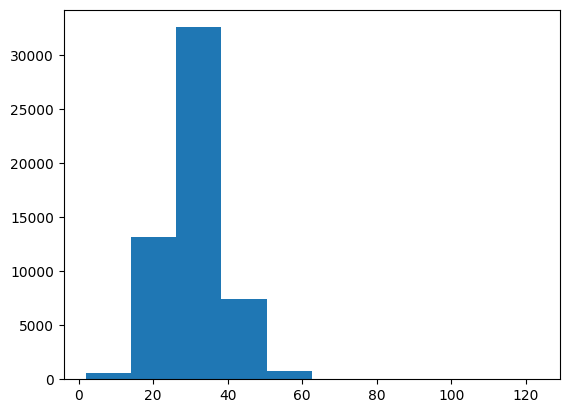

In [17]:
plt.hist(x=df['length'])

#감정분석(필요?)

In [18]:
# # Lets calculate the Polarity of the Reviews, 감정 분석, 한국어라 안됨
# def get_polarity(text):
#     textblob = TextBlob(str(text.encode('utf-8')))
#     pol = textblob.sentiment.polarity
#     return pol

# # lets apply the function
# df['polarity'] = df['제목'].apply(get_polarity)

In [19]:
# def get_subjectivity(text):
#     textblob = TextBlob(str(text.encode('utf-8')))
#     subj = textblob.sentiment.subjectivity
#     return subj

# # lets apply the Function
# df['subjectivity'] = df['제목'].apply(get_subjectivity)

In [20]:
# df[['length','polarity','제목']]

In [21]:
# df[['length','polarity','subjectivity']]

In [22]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 33.2 MB/s eta 0:00:00


In [23]:
!apt-get update -qq
!apt-get install -qq fonts-nanum

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123620 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt

In [25]:
okt=Okt()

In [26]:
def preprocess_korean(text):
    # 특수문자 제거 및 소문자 변환
    text = re.sub(r'\W+', ' ', text)
    # 형태소 분석 후 명사만 추출
    tokens = okt.nouns(text)
    return ' '.join(tokens)

In [27]:
# stop_words = ['은', '는', '이', '가', '을', '를', '에', '의', '와', '한', '하다']

# # CountVectorizer를 사용해 단어 빈도 계산
# cv = CountVectorizer(stop_words=stop_words)
# df['processed_text'] = df['제목'].apply(preprocess_korean)
# words = cv.fit_transform(df['processed_text'])

# # 단어 빈도 계산
# sum_words = words.sum(axis=0)
# words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
# words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# # WordCloud 생성
# wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로 설정
#                       background_color='black',
#                       width=2000,
#                       height=2000).generate_from_frequencies(dict(words_freq))

# # 시각화
# plt.figure(figsize=(10, 10))
# plt.axis('off')
# plt.imshow(wordcloud)
# plt.title("Korean WordCloud", fontsize=20)
# plt.show()

#카테고리를 번호로 치환

In [28]:
# 카테고리 목록과 매핑될 레이블 번호를 생성합니다.
categories = [
    "지역", "경제:부동산", "사회:사건_사고", "경제:반도체", "사회:사회일반", "사회:교육_시험",
    "정치:국회_정당", "사회:의료_건강", "경제:취업_창업", "스포츠:올림픽_아시안게임",
    "경제:산업_기업", "문화:전시_공연", "경제:자동차", "경제:경제일반", "사회:장애인",
    "스포츠:골프", "정치:선거", "경제:유통", "IT_과학:모바일", "사회:여성",
    "사회:노동_복지", "사회:환경", "경제:서비스_쇼핑", "경제:무역", "정치:행정_자치",
    "국제", "문화:방송_연예", "스포츠:축구", "경제:금융_재테크", "정치:청와대",
    "문화:출판", "IT_과학:IT_과학일반", "IT_과학:인터넷_SNS", "문화:미술_건축",
    "정치:정치일반", "IT_과학:과학", "문화:문화일반", "문화:학술_문화재", "문화:요리_여행",
    "경제:자원", "문화:종교", "IT_과학:콘텐츠", "사회:미디어", "사회:날씨",
    "스포츠:농구_배구", "문화:음악", "문화:생활", "IT_과학:보안", "스포츠:월드컵",
    "경제:증권_증시", "정치:북한", "정치:외교", "스포츠:스포츠일반", "문화:영화",
    "스포츠:야구", "경제:외환"
]

# DataFrame을 랜덤하게 섞습니다.
shuffled = df.reindex(np.random.permutation(df.index))

# 각 카테고리에 대해 데이터 샘플링
num_of_categories = 45000
sampled_data = []
for category in categories:
    sampled_data.append(shuffled[shuffled['분류'] == category][:num_of_categories])

# 샘플링된 데이터를 하나의 데이터프레임으로 합칩니다.
concated = pd.concat(sampled_data, ignore_index=True)

# 데이터프레임을 다시 섞습니다.
concated = concated.reindex(np.random.permutation(concated.index))

# LABEL 열 생성 (카테고리별 레이블 부여)
concated['라벨'] = concated['분류'].apply(lambda x: categories.index(x))

# One-hot 인코딩
labels = to_categorical(concated['라벨'], num_classes=len(categories))

# 카테고리 열 삭제
# if '분류' in concated.columns:
#     concated = concated.drop(['분류'], axis=1)

print(concated['라벨'][:10])
print(concated['분류'][:10])
# print(labels[:10])


50445    27
45575    16
10794     0
17344     0
20445     0
46399    17
43556    13
42249    11
35894     4
27306     1
Name: 라벨, dtype: int64
50445      스포츠:축구
45575       정치:선거
10794          지역
17344          지역
20445          지역
46399       경제:유통
43556     경제:경제일반
42249    문화:전시_공연
35894     사회:사회일반
27306      경제:부동산
Name: 분류, dtype: object
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [29]:
n_most_common_words = 20000
max_len = 150
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['제목'].values)
sequences = tokenizer.texts_to_sequences(concated['제목'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 83611 unique tokens.


In [30]:
print ("Shape of X:",len(X))

Shape of X: 54609


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [32]:
epochs = 50
emb_dim = 128
batch_size = 64
labels[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import Add
import tensorflow as tf

In [34]:

# 트랜스포머 블록 정의
def transformer_block(x, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    attention_output = Dropout(dropout)(attention_output)

    # Add & Normalize
    attention_output = Add()([x, attention_output])
    attention_output = LayerNormalization()(attention_output)

    # Feed Forward Network
    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dropout(dropout)(ffn_output)
    ffn_output = Dense(emb_dim)(ffn_output)

    # Add & Normalize
    ffn_output = Add()([attention_output, ffn_output])
    ffn_output = LayerNormalization()(ffn_output)

    return ffn_output


In [35]:

# 입력층
input_layer = Input(shape=(max_len,))

# Embedding 레이어
embedding_layer = Embedding(input_dim=n_most_common_words, output_dim=emb_dim, input_length=max_len)(input_layer)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
# 기본 설정
n_most_common_words = 80000  # 어휘 수 80,000개로 설정
emb_dim = 128  # 임베딩 벡터의 차원 설정
max_len = X.shape[1]  # 시퀀스의 길이 (기사 제목의 길이)
num_heads = 8  # Multi-head attention에서 헤드의 개수
ff_dim = 128  # Feed Forward Network의 출력 차원
num_classes = 56  # 최종 클래스의 개수

In [38]:

# 트랜스포머 블록 적용
x = transformer_block(embedding_layer, emb_dim, num_heads, ff_dim)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# 분류를 위한 Dense 레이어 (56개의 클래스)
output_layer = Dense(num_classes, activation='softmax')(x)

# 모델 정의


In [39]:
model = Model(inputs=input_layer, outputs=output_layer)

In [40]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 150, 128)       │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 150, 128)       │        527,488 │ embedding[0][0],       │
│ (MultiHeadAttention)      │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 150, 128)       │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 150, 128)       │              0 │ embedding[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 150, 128)       │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 150, 128)       │         16,512 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 150, 128)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 150, 128)       │         16,512 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 150, 128)       │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 150, 128)       │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 56)             │          7,224 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,128,248 (11.93 MB)

 Trainable params: 3,128,248 (11.93 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# 컴파일 설정
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# wandb.init(
#     # W&B 프로젝트 이름을 설정
#     project="article classification",

#     # 하이퍼파라미터 및 실행 메타데이터를 추적
#     config={
#         "learning_rate": 0.001,
#         "architecture": "Transformer",
#         "dataset": "titles",
#         "epochs": 10,
#         "max_sequence_length": 130,
#         "embedding_dim": 128,
#         "num_heads": 8,
#         "feedforward_dim": 128,
#         "num_classes": 56
#     }
# )

"""
# 기본 설정
n_most_common_words = 80000  # 어휘 수 80,000개로 설정
emb_dim = 128  # 임베딩 벡터의 차원 설정
max_len = X.shape[1]  # 시퀀스의 길이 (기사 제목의 길이)
num_heads = 8  # Multi-head attention에서 헤드의 개수
ff_dim = 128  # Feed Forward Network의 출력 차원
num_classes = 56  # 최종 클래스의 개수
"""

CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [47]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.01)])

Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.4927 - loss: 2.5310 - val_accuracy: 0.5773 - val_loss: 1.8786
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.6424 - loss: 1.5104 - val_accuracy: 0.6631 - val_loss: 1.4325
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8060 - loss: 0.7230 - val_accuracy: 0.6658 - val_loss: 1.5904
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8941 - loss: 0.3671 - val_accuracy: 0.6548 - val_loss: 1.8628
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9356 - loss: 0.2109 - val_accuracy: 0.6473 - val_loss: 2.1422
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9549 - loss: 0.1412 - val_accuracy: 0.6437 - val_loss: 2.3231
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9643 - loss: 0.1142 - val_accuracy: 0.6372 - val_loss: 2.5651
Epoch 8/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9687 - loss: 0.0947 - 

In [48]:
# 모델 전체를 저장하는 코드 (모델 아키텍처, 가중치, 컴파일 정보 포함)
model.save('/content/drive/MyDrive/코딩공부/dacon_project/result/bbc_edit_model.h5')  # 모델을 'model.h5' 파일로 저장

print("모델이 'bbc_edit_model.h5'로 저장되었습니다.")


모델이 'bbc_edit_model.h5'로 저장되었습니다.


In [49]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6444 - loss: 2.8473
Test set
  Loss: 2.847
  Accuracy: 0.643


In [61]:
df = pd.read_csv('/content/drive/MyDrive/코딩공부/dacon_project/data/train.csv')
category_counts = df['분류'].value_counts()

# 결과를 출력합니다.
print(category_counts[:40])

분류
지역               26950
경제:부동산            3454
사회:사건_사고          2568
경제:반도체            2318
사회:사회일반           1480
사회:교육_시험           995
정치:국회_정당           966
사회:의료_건강           950
경제:취업_창업           845
스포츠:올림픽_아시안게임      841
경제:산업_기업           711
문화:전시_공연           671
경제:자동차             640
경제:경제일반            625
사회:장애인             621
스포츠:골프             617
정치:선거              608
경제:유통              589
IT_과학:모바일          537
사회:여성              536
사회:노동_복지           447
사회:환경              396
경제:서비스_쇼핑          387
경제:무역              375
정치:행정_자치           349
국제                 337
문화:방송_연예           335
스포츠:축구             328
경제:금융_재테크          327
정치:청와대             279
문화:출판              248
IT_과학:IT_과학일반      243
IT_과학:인터넷_SNS      238
문화:미술_건축           229
정치:정치일반            221
IT_과학:과학           215
문화:문화일반            213
문화:학술_문화재          202
문화:요리_여행           190
경제:자원              178
Name: count, dtype: int64


In [50]:
txt = ["용인특례시, 가을 신학기 학교 급식 공급업체 위생점검"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
# labels = [
#     "지역", "경제:부동산", "사회:사건_사고", "경제:반도체", "사회:사회일반", "사회:교육_시험",
#     "정치:국회_정당", "사회:의료_건강", "경제:취업_창업", "스포츠:올림픽_아시안게임",
#     "경제:산업_기업", "문화:전시_공연", "경제:자동차", "경제:경제일반", "사회:장애인",
#     "스포츠:골프", "정치:선거", "경제:유통", "IT_과학:모바일", "사회:여성",
#     "사회:노동_복지", "사회:환경", "경제:서비스_쇼핑", "경제:무역", "정치:행정_자치",
#     "국제", "문화:방송_연예", "스포츠:축구", "경제:금융_재테크", "정치:청와대",
#     "문화:출판", "IT_과학:IT_과학일반", "IT_과학:인터넷_SNS", "문화:미술_건축",
#     "정치:정치일반", "IT_과학:과학", "문화:문화일반", "문화:학술_문화재", "문화:요리_여행",
#     "경제:자원", "문화:종교", "IT_과학:콘텐츠", "사회:미디어", "사회:날씨",
#     "스포츠:농구_배구", "문화:음악", "문화:생활", "IT_과학:보안", "스포츠:월드컵",
#     "경제:증권_증시", "정치:북한", "정치:외교", "스포츠:스포츠일반", "문화:영화",
#     "스포츠:야구", "경제:외환"
# ]
labels = [ #40개 레이블만 있음
    "지역", "경제:부동산", "사회:사건_사고", "경제:반도체", "사회:사회일반", "사회:교육_시험",
    "정치:국회_정당", "사회:의료_건강", "경제:취업_창업", "스포츠:올림픽_아시안게임",
    "경제:산업_기업", "문화:전시_공연", "경제:자동차", "경제:경제일반", "사회:장애인",
    "스포츠:골프", "정치:선거", "경제:유통", "IT_과학:모바일", "사회:여성",
    "사회:노동_복지", "사회:환경", "경제:서비스_쇼핑", "경제:무역", "정치:행정_자치",
    "국제", "문화:방송_연예", "스포츠:축구", "경제:금융_재테크", "정치:청와대",
    "문화:출판", "IT_과학:IT_과학일반", "IT_과학:인터넷_SNS", "문화:미술_건축",
    "정치:정치일반", "IT_과학:과학", "문화:문화일반", "문화:학술_문화재", "문화:요리_여행",
    "경제:자원"
]
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
[[9.98412609e-01 2.22086939e-07 3.99931679e-08 3.78673052e-04
  2.06995750e-07 2.82290216e-06 4.12183472e-05 1.56080726e-09
  1.61052105e-06 6.94427911e-07 1.18027299e-06 1.25589022e-05
  2.40243071e-06 6.23646065e-06 1.71414783e-07 6.16277163e-09
  1.22818892e-06 8.09813064e-05 2.85256760e-08 1.11619924e-09
  1.98393718e-06 5.96274788e-07 7.16714297e-08 2.29931985e-07
  4.28159765e-05 4.13552743e-06 6.33720205e-08 8.45911288e-08
  2.42224189e-07 4.82460127e-05 8.12687631e-06 4.27517716e-06
  5.51150947e-08 3.55429597e-06 1.68993589e-04 4.47888169e-06
  7.20086900e-05 7.53527784e-05 3.69306605e-07 7.99896588e-06
  1.87800637e-08 2.12353214e-07 6.39909548e-09 3.76868066e-08
  7.16829121e-08 3.20399122e-04 1.69156522e-07 6.06155072e-06
  1.12355465e-07 2.25031744e-08 2.83957546e-04 8.58984606e-07
  1.11357588e-06 2.24755610e-07 1.03855493e-08 1.82688439e-07]] 지역


In [58]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. test.csv 파일 로드
test_df = pd.read_csv('/content/drive/MyDrive/코딩공부/dacon_project/data/test.csv')

# 2. 데이터 전처리: 제목을 시퀀스로 변환
# 학습 시 사용했던 tokenizer를 사용하여 제목을 시퀀스로 변환
sequences_test = tokenizer.texts_to_sequences(test_df['제목'].values)

# 3. 시퀀스의 길이를 동일하게 맞추기 (max_len에 맞춰 패딩)
X_test = pad_sequences(sequences_test, maxlen=max_len)

# 4. 모델을 사용하여 예측
predictions = model.predict(X_test)

# 5. 예측 결과에서 가장 확률이 높은 클래스를 추출
predicted_labels = predictions.argmax(axis=1)

predicted_class_names=[categories[label] for label in predicted_labels]

# 6. submission 데이터프레임 생성 (id와 예측된 레이블을 저장)
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    '분류': predicted_class_names
})

# 7. submission.csv 파일로 저장
submission_df.to_csv('/content/drive/MyDrive/코딩공부/dacon_project/result/submission.csv', index=False)

print("Submission 파일이 생성되었습니다.")


732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Submission 파일이 생성되었습니다.


In [62]:
df=pd.read_csv('/content/drive/MyDrive/코딩공부/dacon_project/result/submission.csv')
print("Shpe of Data",df.shape)
df.head(10)

Shpe of Data (23405, 2)


,ID,분류
0,TEST_00000,지역
1,TEST_00001,사회:사회일반
2,TEST_00002,지역
3,TEST_00003,경제:취업_창업
4,TEST_00004,지역
5,TEST_00005,지역
6,TEST_00006,지역
7,TEST_00007,문화:문화일반
8,TEST_00008,사회:사건_사고
9,TEST_00009,지역


/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('분류').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('분류').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('분류')):
  _plot_series(series, series_name, i)
  fig.legend(title='분류', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) miss

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['분류'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='index', y='분류', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)